In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaForSequenceClassification, RobertaTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from lime.lime_text import LimeTextExplainer
import ast
from collections import defaultdict

## Calculare LIME 

In [2]:
class TemperatureScaler(nn.Module):
    def __init__(self):
        super(TemperatureScaler, self).__init__()
        # Folosim un parametru log_temperature pentru a asigura T > 0 (T = exp(log_temperature))
        self.log_temperature = nn.Parameter(torch.zeros(1))
    
    def forward(self, logits):
        temperature = torch.exp(self.log_temperature)
        return logits / temperature

In [3]:
class CalibratedModel(nn.Module):
    def __init__(self, model, temp_scaler):
        super(CalibratedModel, self).__init__()
        self.model = model
        self.temp_scaler = temp_scaler
    
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        # Aplicăm temperature scaling
        scaled_logits = self.temp_scaler(logits)
        # Obținem probabilitățile calibrate
        calibrated_probs = F.softmax(scaled_logits, dim=-1)
        return calibrated_probs

In [4]:
model_path = "saved_models/roberta/roberta_torch_model"
tokenizer_path = "saved_models/roberta/roberta_tokenizer"
calibrated_model_path = "saved_models/roberta/calibrated_model.pth"

In [5]:
model = RobertaForSequenceClassification.from_pretrained(model_path)
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)

In [6]:
temp_scaler = TemperatureScaler()
calibrated_model = CalibratedModel(model, temp_scaler)

In [8]:
df = pd.read_csv("../../datasets/CC_WELF_merged_cleaned.csv")

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [ ]:

def wordopt(text):
    text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text)
    text = text.replace('\n', ' ')
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [17]:
X_test = X_test.tolist()

In [14]:
def get_predictions(texts, model, tokenizer, batch_size=16):
    predictions = []
    probabilities = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts, return_tensors="pt", 
                            padding="max_length", truncation=True, max_length=512)
        with torch.no_grad():
            probs = model(input_ids=encoded["input_ids"], attention_mask=encoded["attention_mask"])
            # Extragem clasa cu probabilitatea maximă pentru fiecare exemplu
            pred_classes = torch.argmax(probs, dim=-1)
            predictions.extend(pred_classes.cpu().numpy().tolist())
            probabilities.extend(probs.cpu().numpy().tolist())
    return predictions, probabilities

In [19]:
preds, probs = get_predictions(X_test, calibrated_model, tokenizer, batch_size=16)

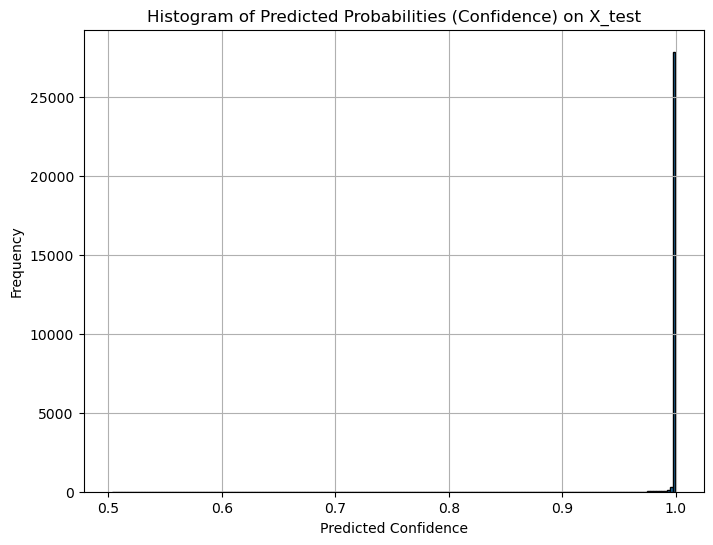

In [ ]:


# Convertim lista de probabilități într-un array NumPy
probs_array = np.array(probs)  # presupunem că 'probs' este o listă de liste, fiecare cu probabilități pe clase

# Calculăm "confidence" pentru fiecare exemplu (maximul din fiecare rând)
confidences = np.max(probs_array, axis=1)

# Desenăm histograma
plt.figure(figsize=(8, 6))
plt.hist(confidences, bins=200, edgecolor='black')
plt.xlabel("Predicted Confidence")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Probabilities (Confidence) on X_test")
plt.grid(True)
plt.show()

In [22]:
df_results = pd.DataFrame({
    'text': X_test,
    'true_label': y_test,
    'predicted_label': preds,
    'predicted_probs': [str(prob) for prob in probs],  # conversie la string pentru a salva vectorul
    'confidence': [max(prob) for prob in probs]         # maximul din vectorul de probabilități
})

# Salvează DataFrame-ul într-un fișier CSV
df_results.to_csv("predictions.csv", index=False)
print("Predicțiile au fost salvate în fișierul 'predictions.csv'.")

Predicțiile au fost salvate în fișierul 'predictions.csv'.


In [23]:
df_wrong = df_results[df_results['true_label'] != df_results['predicted_label']]
len(df_wrong)

184

In [24]:
df_wrong.sample(10)

,text,true_label,predicted_label,predicted_probs,confidence
64639,First Dog on the Moon on the land of the fair go,1,0,"[0.9903054237365723, 0.009694619104266167]",0.990305
51711,Most of you are aware of a growing movement am...,1,0,"[0.9172393679618835, 0.08276058733463287]",0.917239
82217,Click here to contribute your book! For more i...,1,0,"[0.8908037543296814, 0.1091962605714798]",0.890804
106671,", . , , , , . ( ), , , . 70- , (, ). . , , . ,...",0,1,"[0.37336960434913635, 0.626630425453186]",0.626630
60601,Brandisgate: this is an important issue so we ...,1,0,"[0.9961100220680237, 0.003890021238476038]",0.996110
14269,DIRECTIONS: Name the magazine in which these f...,0,1,"[0.004507343750447035, 0.9954925775527954]",0.995493
4449,Aries: (Mar. 21Apr. 19) Youll meet a handsome ...,0,1,"[0.059582918882369995, 0.9404171109199524]",0.940417
113055,Photo of the day: Honor guard Reuters A honor ...,0,1,"[0.008225261233747005, 0.9917746782302856]",0.991775
54341,San Diego Comic-Con is expected to draw more t...,0,1,"[0.1997203379869461, 0.8002796173095703]",0.800280
122866,Bills past Bill Clintons controversial past wa...,0,1,"[0.3375968337059021, 0.6624031662940979]",0.662403


In [25]:
#delete the ones with less than 30 words
df_wrong = df_wrong[df_wrong['text'].apply(lambda x: len(x.split()) > 30)]
len(df_wrong)

142

In [28]:
#show me the text of the one with [0.37336960434913635, 0.626630425453186] predicted_probs
df_wrong[df_wrong['predicted_probs'] == '[0.37336960434913635, 0.626630425453186]']

,text,true_label,predicted_label,predicted_probs,confidence


In [29]:
#delete the ones with less than 30 alphabetic characters
df_wrong = df_wrong[df_wrong['text'].apply(lambda x: len(re.sub(r'[^a-zA-Z]', '', x)) > 30)]
df_wrong.sample(10)



,text,true_label,predicted_label,predicted_probs,confidence
139851,"Melanija Knavs-Trump was born on April 26, 197...",0,1,"[0.011909235268831253, 0.9880907535552979]",0.988091
82237,A record number of Americans are expected to t...,1,0,"[0.9367913007736206, 0.06320870667695999]",0.936791
80743,Boy recants published story of visiting heaven...,0,1,"[0.11670175194740295, 0.8832982778549194]",0.883298
82345,"A total of $114 billion, which does not includ...",1,0,"[0.9908893704414368, 0.009110640734434128]",0.990889
102774,Is a war in the making a third world war? If t...,0,1,"[0.005313734523952007, 0.9946862459182739]",0.994686
136467,PRESIDENT TRUMP AND FIRST LADY MELANIA TRUMP A...,0,1,"[0.013798193074762821, 0.986201822757721]",0.986202
135965,Awkward does not even come close to describing...,0,1,"[0.005417629145085812, 0.9945823550224304]",0.994582
137159,From Bloomberg: London-based gold dealer Sharp...,0,1,"[0.32575225830078125, 0.6742478013038635]",0.674248
102168,Looking for a way to help relieve stress in a ...,1,0,"[0.7447943091392517, 0.2552056908607483]",0.744794
61225,"Its Monday morning, and Toronto resident Steve...",0,1,"[0.04072197154164314, 0.9592779874801636]",0.959278


In [30]:
len(df_wrong)

139

In [35]:
#how many have confidence > 0.6 and < 0.7
len(df_wrong[(df_wrong['confidence'] > 0.6) & (df_wrong['confidence'] < 0.7)])

13

In [38]:
# Definește clasa LIME (0 = FAKE, 1 = REAL)
class_names = ["FAKE", "REAL"]
explainer = LimeTextExplainer(class_names=class_names)

# Funcția de predicție pentru LIME (primește o listă de texte și returnează probabilități)
def lime_predict_proba(texts):
    encoded = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        output = model(input_ids=encoded["input_ids"], attention_mask=encoded["attention_mask"])
        logits = output.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
    return probs.cpu().numpy()

# Listă pentru a stoca explicațiile
lime_explanations = []

# Iterează prin textele din df_wrong
for i, row in df_wrong.iterrows():
    text = row['text']
    explanation = explainer.explain_instance(
        text,
        lime_predict_proba,
        num_features=10,
        num_samples=1000
    )
    
    # Salvăm doar contribuțiile sub formă de listă [(word, importance), ...]
    lime_explanations.append(explanation.as_list())

# Adaugă rezultatele în DataFrame
df_wrong['lime_explanations'] = lime_explanations

# Salvează într-un fișier CSV
df_wrong.to_csv("lime_wrong_predictions.csv", index=False)
print("Explicațiile LIME au fost salvate în lime_wrong_predictions.csv.")

Explicațiile LIME au fost salvate în lime_wrong_predictions.csv.


## Analiza explicatii LIME

In [9]:
df_wrong_predictions = pd.read_csv("lime_wrong_predictions.csv")

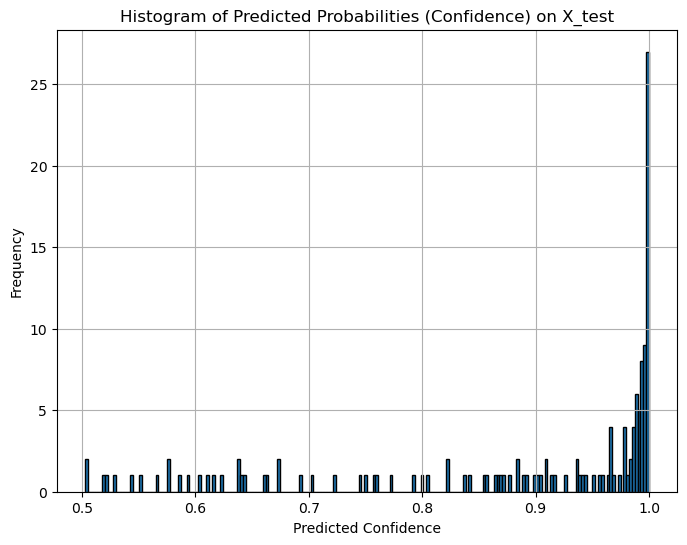

In [10]:
confidences = df_wrong_predictions['confidence'].tolist()
plt.figure(figsize=(8, 6))
plt.hist(confidences, bins=200, edgecolor='black')
plt.xlabel("Predicted Confidence")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Probabilities (Confidence) on X_test")
plt.grid(True)
plt.show()

In [11]:
true_articles = df_wrong_predictions[df_wrong_predictions['true_label'] == 1]
false_articles = df_wrong_predictions[df_wrong_predictions['true_label'] == 0]
print("True articles: ", len(true_articles))
print("False articles: ", len(false_articles))

True articles:  49
False articles:  90


Text(0.5, 1.0, 'Distribuția predicțiilor greșite')

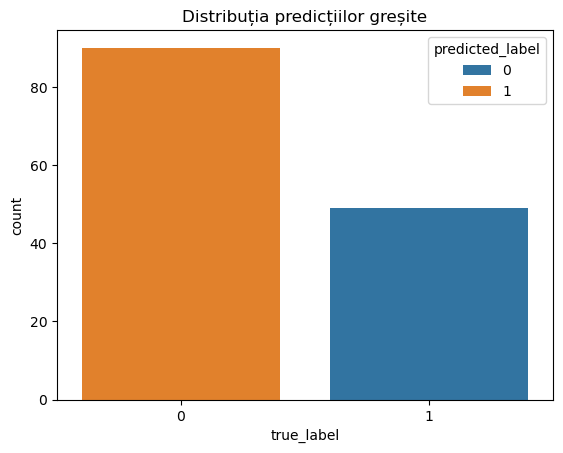

In [17]:
sns.countplot(data=df_wrong_predictions, x='true_label', hue='predicted_label')
plt.title("Distribuția predicțiilor greșite")

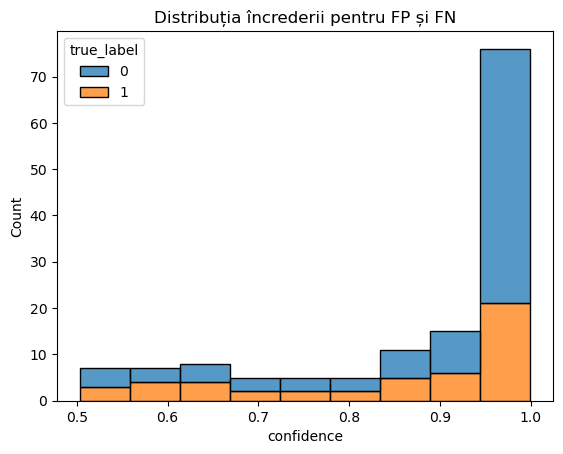

In [14]:
sns.histplot(data=df_wrong_predictions, x='confidence', hue='true_label', multiple='stack')
plt.title("Distribuția încrederii pentru FP și FN")
plt.show()

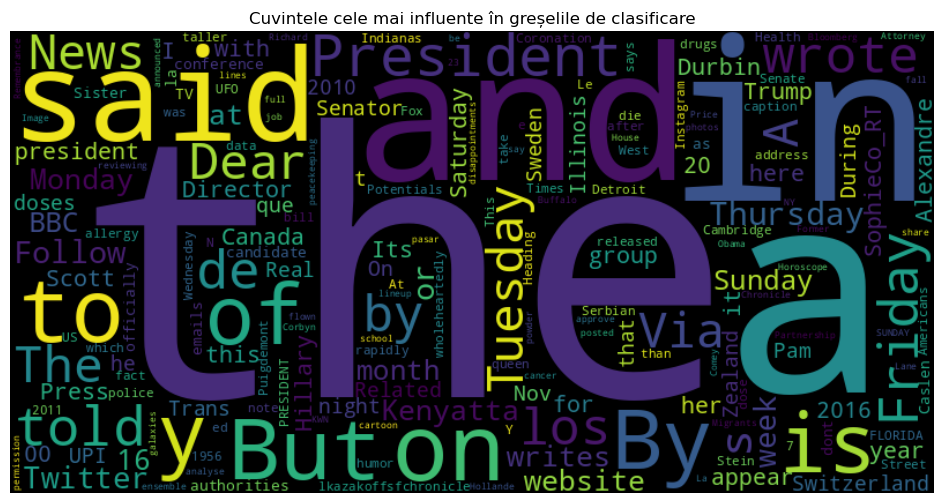

In [26]:
all_contributions = []

for row in df_wrong_predictions["lime_explanations"]:
    try:
        parsed = ast.literal_eval(row)
        if isinstance(parsed, list):
            all_contributions.extend(parsed)
    except Exception as e:
        print(f"Eroare la parsare: {e}")

# Construim un dicționar cu frecvențele/ponderile cuvintelor
word_freq = {}
for word, importance in all_contributions:
    if word in word_freq:
        word_freq[word] += abs(importance)  # suma absolută a importanței
    else:
        word_freq[word] = abs(importance)

# Generăm word cloud-ul
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)

# Afișăm graficul
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Cuvintele cele mai influente în greșelile de clasificare")
plt.show()

Text(0.5, 1.0, 'Distribuția lungimii textelor clasificate greșit')

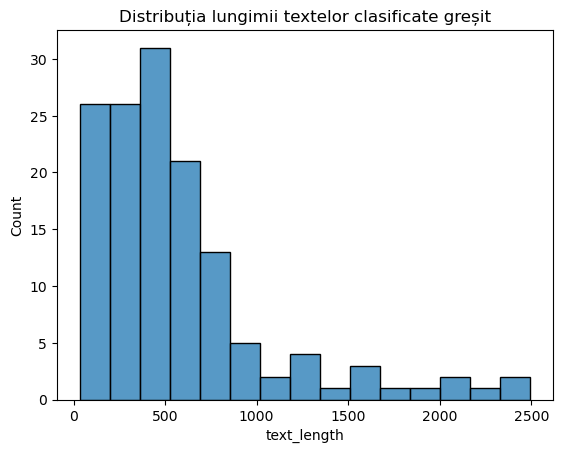

In [22]:
df_wrong_predictions['text_length'] = df_wrong_predictions['text'].apply(lambda x: len(x.split()))
sns.histplot(df_wrong_predictions['text_length'])
plt.title("Distribuția lungimii textelor clasificate greșit")

In [23]:
df_wrong_predictions.sort_values(by='confidence', ascending=False).head(10)


,text,true_label,predicted_label,predicted_probs,confidence,lime_explanations,text_length
50,Facebook says users can't stop it from using b...,0,1,"[0.0002606005291454494, 0.9997393488883972]",0.999739,"[('data', 0.1797912250055458), ('photos', 0.14...",208
91,When the liberal class heard news media report...,0,1,"[0.00029446653206832707, 0.9997054934501648]",0.999705,"[('the', 0.36970218315887365), ('Stein', 0.189...",2495
78,"Conservatives propose divided New York ALBANY,...",0,1,"[0.0003753798664547503, 0.9996246099472046]",0.999625,"[('and', 0.2588928325556451), ('Y', 0.17101799...",682
38,An enthusiast with a keen attention to detail ...,1,0,"[0.999518871307373, 0.0004810834943782538]",0.999519,"[('Revealed', -0.0030248535501511855), ('Stash...",258
83,The former Alaska Governor Sarah Palin would b...,1,0,"[0.9994080066680908, 0.0005920006078667939]",0.999408,"[('Governor', -0.0035523506343958645), ('Addit...",177
79,I would like to briefly sum up the message fro...,0,1,"[0.0006265076226554811, 0.9993734955787659]",0.999373,"[('the', 0.2260813753474711), ('I', 0.13501453...",1788
76,Reuters On a rooftop overlooking the walls of ...,0,1,"[0.000634111522231251, 0.9993658661842346]",0.999366,"[('said', 0.18933957211683383), ('to', 0.15835...",542
81,Obama's Presidential Library Will Be In Chicag...,1,0,"[0.9993367791175842, 0.0006631725118495524]",0.999337,"[('Announces', -0.007979977840359842), ('Obama...",142
62,Wisconsin police were widening their hunt Satu...,0,1,"[0.0009755028877407312, 0.999024510383606]",0.999025,"[('a', 0.2405159790433539), ('police', 0.17814...",221
60,The Higgs boson has been everywhere these days...,0,1,"[0.0010223824065178633, 0.9989776611328125]",0.998978,"[('TV', 0.2064618787098082), ('West', 0.196470...",466


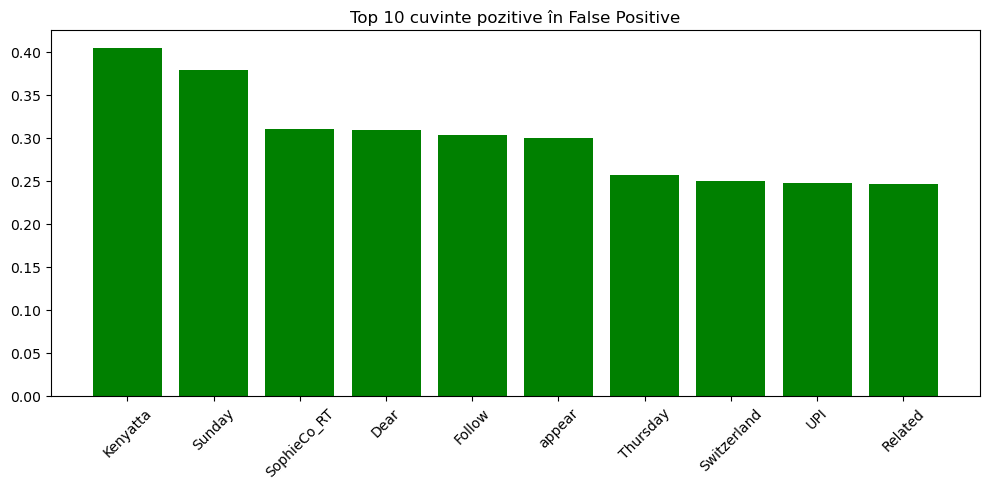

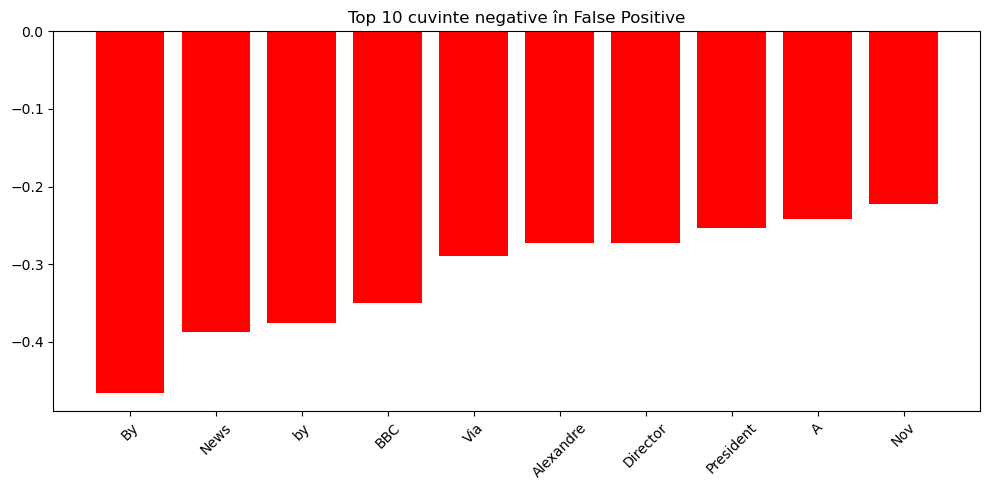

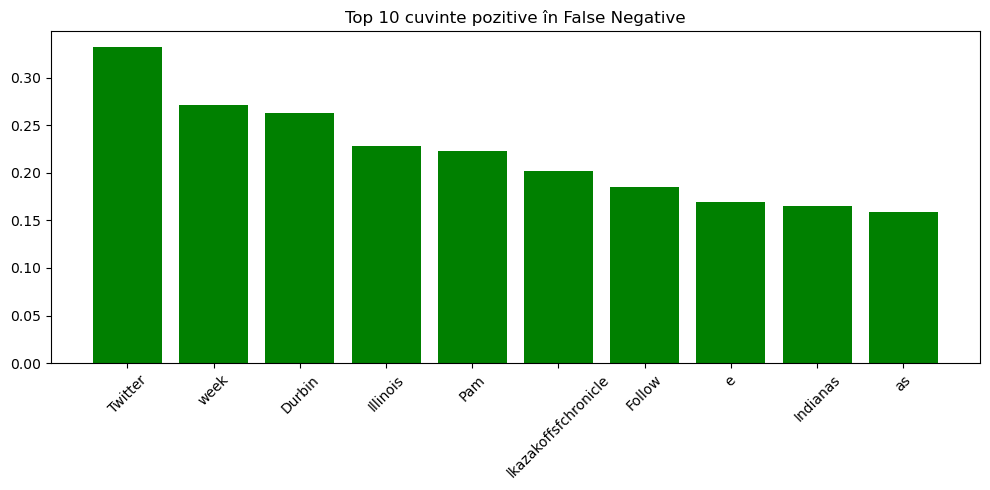

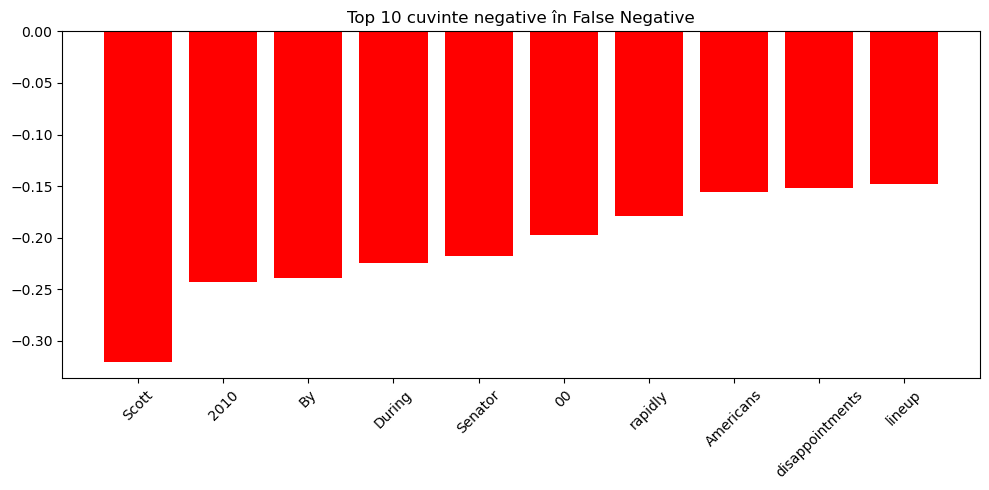

In [ ]:
fp_df = df_wrong_predictions[(df_wrong_predictions["true_label"] == 0) & (df_wrong_predictions["predicted_label"] == 1)]
fn_df = df_wrong_predictions[(df_wrong_predictions["true_label"] == 1) & (df_wrong_predictions["predicted_label"] == 0)]

def get_top_contributions(df, top_n=10):
    positive_contributions = defaultdict(list)
    negative_contributions = defaultdict(list)

    for row in df["lime_explanations"]:
        try:
            parsed = ast.literal_eval(row)
            for word, importance in parsed:
                if importance > 0:
                    positive_contributions[word].append(importance)
                elif importance < 0:
                    negative_contributions[word].append(importance)
        except:
            continue

    # Calculează media importanței
    pos_avg = {w: sum(vals)/len(vals) for w, vals in positive_contributions.items()}
    neg_avg = {w: sum(vals)/len(vals) for w, vals in negative_contributions.items()}

    top_pos = sorted(pos_avg.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_neg = sorted(neg_avg.items(), key=lambda x: x[1])[:top_n]

    return top_pos, top_neg

fp_pos, fp_neg = get_top_contributions(fp_df)
fn_pos, fn_neg = get_top_contributions(fn_df)

def plot_bar_chart(data, title, color):
    words, scores = zip(*data)
    plt.figure(figsize=(10,5))
    plt.bar(words, scores, color=color)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_bar_chart(fp_pos, "Top 10 cuvinte pozitive în False Positive", "green")
plot_bar_chart(fp_neg, "Top 10 cuvinte negative în False Positive", "red")

plot_bar_chart(fn_pos, "Top 10 cuvinte pozitive în False Negative", "green")
plot_bar_chart(fn_neg, "Top 10 cuvinte negative în False Negative", "red")

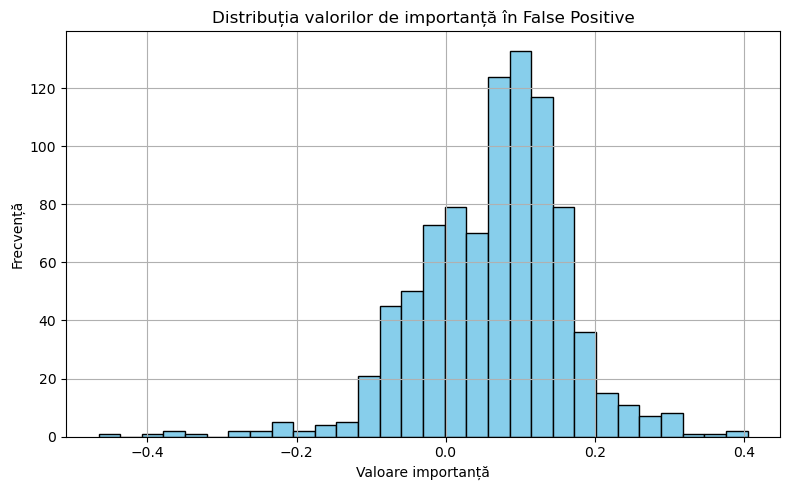

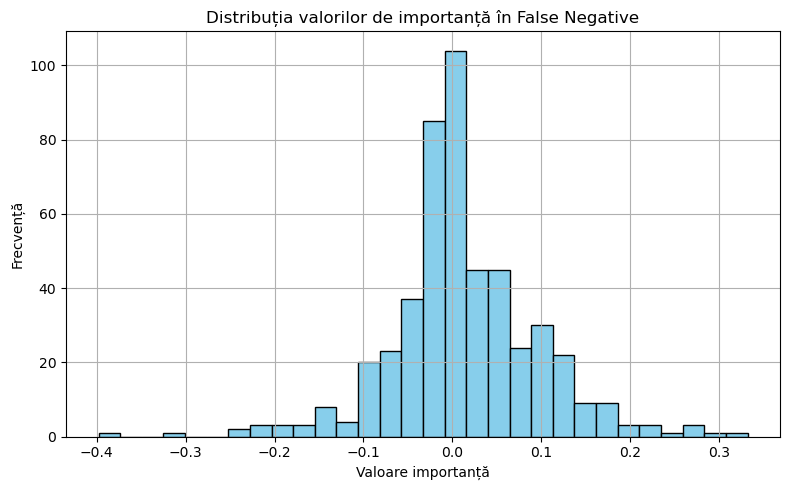

In [29]:
def plot_importance_distribution(df, label):
    all_importance = []
    for row in df["lime_explanations"]:
        try:
            parsed = ast.literal_eval(row)
            all_importance.extend([importance for _, importance in parsed])
        except:
            continue

    plt.figure(figsize=(8,5))
    plt.hist(all_importance, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Distribuția valorilor de importanță în {label}")
    plt.xlabel("Valoare importanță")
    plt.ylabel("Frecvență")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_importance_distribution(fp_df, "False Positive")
plot_importance_distribution(fn_df, "False Negative")